In [17]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt

# Check if CUDA is available
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

# Set GPU growth to allow dynamic allocation of memory
for gpu in physical_devices:
    if gpu.device_type == 'GPU':
        tf.config.experimental.set_memory_growth(gpu, True)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
# Load training data
df_train = pd.read_csv('../Datasets/RefSeq.csv')

X_train = np.array(df_train.drop(['class'], axis=1)).astype('float32')
y_train = np.array(df_train['class'])
y_train = LabelEncoder().fit_transform(y_train)

# Load test data
df_test = pd.read_csv('../Datasets/CompSeq.csv')

X_test = np.array(df_test.drop(['class'], axis=1)).astype('float32')
y_test = np.array(df_test['class'])
y_test = LabelEncoder().fit_transform(y_test)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_shape = (X_train_scaled.shape[1], 1)

In [19]:
# Create LSTM model
def create_improved_rnn_model(input_shape, num_classes):
    model = Sequential([
        LSTM(200, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(100),
        Dense(100, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
improved_rnn_model = create_improved_rnn_model(input_shape, len(np.unique(y_train)))

/home/kav_k/anaconda3/envs/myEnv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

Epoch 1/150
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 140s 11ms/step - accuracy: 0.4543 - loss: 2.4854 - val_accuracy: 0.9825 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 2/150
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 139s 11ms/step - accuracy: 0.9764 - loss: 0.0785 - val_accuracy: 0.9941 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 3/150
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 139s 11ms/step - accuracy: 0.9886 - loss: 0.0378 - val_accuracy: 0.9970 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 4/150
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - accuracy: 0.9918 - loss: 0.0272 - val_accuracy: 0.9976 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 5/150
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 140s 11ms/step - accuracy: 0.9937 - loss: 0.0213 - val_accuracy: 0.9961 - val_loss: 0.0157 - learning_rate: 0.0010
Epoch 6/150
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 139s 11ms/step - accuracy: 0.9948 - loss: 0.0177 - val_accuracy: 0.9973 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 7/150
13108/13108 ━━━━━━━━━━━━━━━━

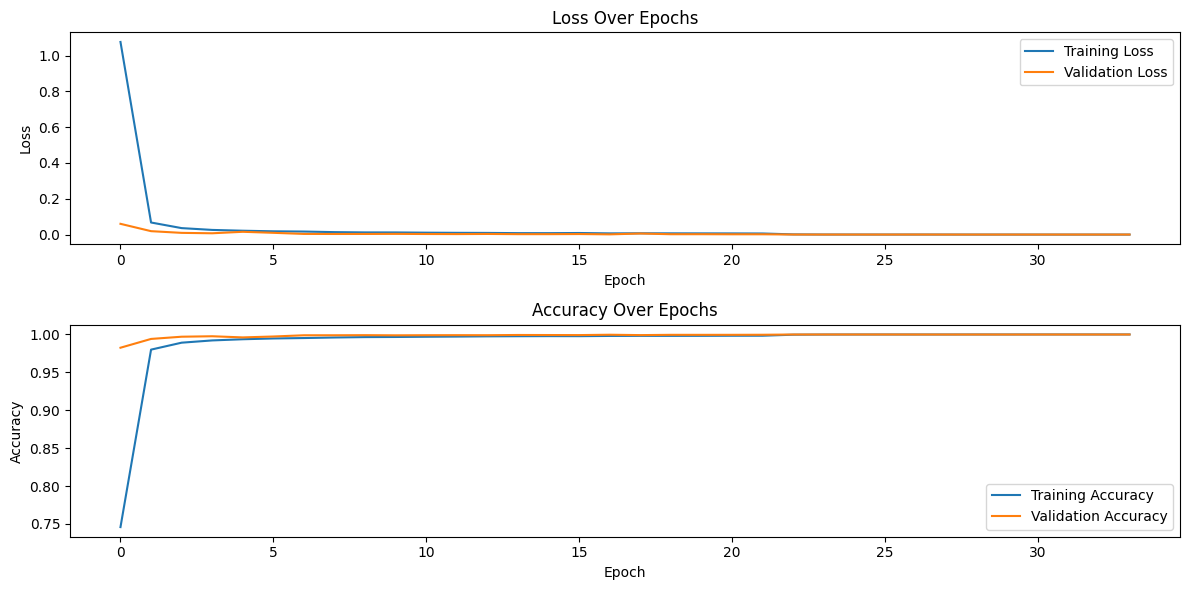

In [21]:
start_train = time.time()
# Train the model
history = improved_rnn_model.fit(
    X_train_scaled.reshape(X_train_scaled.shape[0], *input_shape),
    y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
end_train = time.time()
print("Training Evaluation Time: {0:.5} seconds \n".format(end_train-start_train))

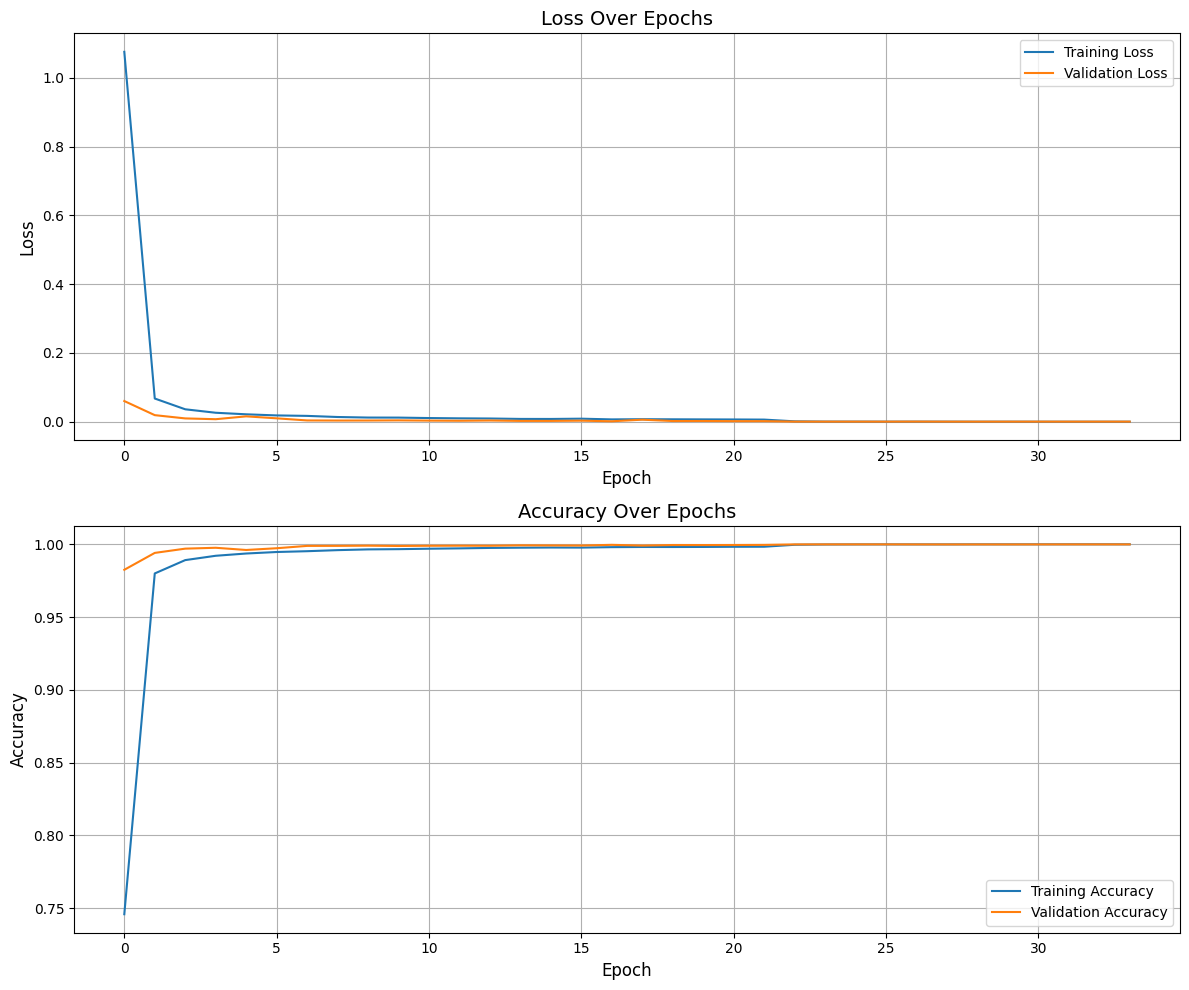

In [27]:
# Visualize learning curves
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
start = time.time()
# Evaluate the model on the test set
test_loss, test_accuracy = improved_rnn_model.evaluate(X_test_scaled.reshape(X_test_scaled.shape[0], *input_shape), y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

# Predictions
predictions = improved_rnn_model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], *input_shape))
predicted_classes = np.argmax(predictions, axis=1)
end = time.time()
print("Testing Evaluation Time: {0:.5} seconds \n".format(end-start))

# Calculate metrics
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes, average='macro')
recall = recall_score(y_test, predicted_classes, average='macro')
f1 = f1_score(y_test, predicted_classes, average='macro')

# Print metrics
print("Accuracy   :", accuracy)
print("Precision  :", precision)
print("Recall     :", recall)
print("F1 Score   :", f1)

Test Accuracy: 0.9996490478515625
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Testing Evaluation Time: 12.343 seconds 

Accuracy   : 0.9996490478515625
Precision  : 0.9996120650972242
Recall     : 0.9976878057323058
F1 Score   : 0.9983202476002775


In [23]:
# Save metrics to a CSV file
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('../Metrics_Files/Bilstm_Metrics.csv', index=False)
print("Metrics stored into Bilstm_Metrics.csv")

Metrics stored into Bilstm_Metrics.csv


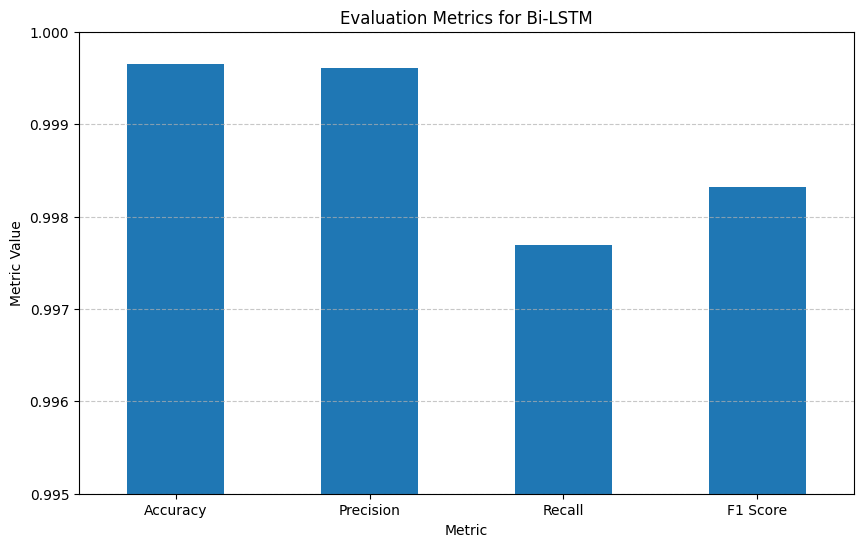

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '../Metrics_Files/Bilstm_Metrics.csv'  # Replace with your actual file path
metrics_df = pd.read_csv(file_path)

# Set the metric as the index for better visualization
metrics_df.set_index('Metric', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(metrics_df))  # Use seaborn's husl palette

# Create a bar plot
metrics_df['Value'].plot(kind='bar')

# Customizing the plot
plt.title('Evaluation Metrics for Bi-LSTM')
plt.ylabel('Metric Value')
plt.ylim(0.995, 1)  # Set the y-axis limit
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()